In [ ]:
import pymssql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.backends.backend_pdf

In [ ]:
database = "arctic_analysts_capstone"
user = "arctic_analysts"
password  = "ThisPassw0rd!"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"

def sql_query(query):
    conn = pymssql.connect(server, user, password, database)
    cursor = conn.cursor()
    queried_data = pd.read_sql(query, conn)
    return queried_data


tables = [
    'year',
    'month',
    'county',
    'median_income',
    'main_table'
]

query = f"SELECT * FROM {tables[0]}" # Query Example
year_df = sql_query(query)

query = f"SELECT * FROM {tables[1]}" # Query Example
month_df = sql_query(query)

query = f"SELECT * FROM {tables[2]}" # Query Example
county_df = sql_query(query)

query = f"SELECT * FROM {tables[3]}" # Query Example
median_income_df = sql_query(query)

query = f"SELECT * FROM {tables[4]}" # Query Example
main_table = sql_query(query)


master_table = pd.merge(main_table, year_df, left_on = 'YearID', right_on = 'YearID', how = 'inner')
# Now has 5607 rows

master_table = pd.merge(master_table, month_df, left_on = 'MonthID', right_on = 'MonthID', how = 'inner')
# Now has 5607 rows

master_table = pd.merge(master_table, county_df, left_on = 'FIPS', right_on = 'FIPS', how = 'inner')
# Now has 5607 rows

master_table = pd.merge(master_table, median_income_df, left_on = ['FIPS','YearID'], right_on = ['FIPS','YearID'], how = 'inner')
# Now has 18900 rows

master_table = master_table.drop(columns = ['YearID','MonthID'])

In [ ]:
def convert_to_date(year, month):
    date = dt.datetime.strptime(f'{year}-{month}-15', '%Y-%b-%d').date()
    date = dt.datetime.strftime(date, '%Y-%m-%d')
    return date

master_table['date'] = master_table.apply(lambda row: convert_to_date(row.Year, row.Month), axis = 1)

filtered = master_table[(master_table['AgeGroup'] == '25-44')].copy()

In [235]:
m = 'Please see the file named "polynomial_models.pdf" for the results.'

# need residuals for the machine learning
# need some graphs to explain the machine learning
def run_predictions(X, y, dependent_var, degree):
    Input=[('polynomial', PolynomialFeatures(degree=degree)),('modal',LinearRegression())]

    pipe=Pipeline(Input)

    pipe.fit(X,y)

    poly_pred = pipe.predict(X)

    sorted_zip = sorted(zip(X['predictor'].tolist(), poly_pred))

    x_poly, poly_pred = zip(*sorted_zip)
    return pipe, x_poly, poly_pred, np.sqrt(mean_squared_error(y,poly_pred))

def graph_best(x_poly, poly_pred, degree, county):
    
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13
    #plt.rcParams['legend.title_fontsize'] = 'xx-large'
    fig = plt.figure(figsize = (20,8))
    plt.title(f'FIPS: {county} | {dependent_var} | Degree: {degree}', fontsize = 32)
    ax = sns.scatterplot(data = county_filtered,
                         x = county_filtered['predictor'],
                         y = dependent_var,
                         hue = dependent_var,
                         palette = 'magma', 
                         s = 100,
                         alpha = .32, 
                         edgecolor = 'black', 
                         linewidth = 1,
                         legend = False)

    plt.plot(x_poly, poly_pred, color = 'green', linewidth = 4, linestyle= 'dashed', label = 'Polynomial Regression')

    ax.set_xlabel('Predictor', fontsize = 14)
    ax.set_ylabel('Target', fontsize = 14)
    ax.tick_params(size = 10)
    ax.legend(fontsize = 18, markerscale = 1, loc = 5)
    sns.despine()
    plt.close()
    return fig

In [237]:
counties = filtered.FIPS.unique().tolist()
print('Please wait, building models... ')
pdf = matplotlib.backends.backend_pdf.PdfPages(f"polynomial_models.pdf")
best_models = {}
outputs = []
for county in counties:
    best_models[county] = {}
    county_filtered = filtered[(filtered.FIPS == county)].copy()

    county_filtered.sort_values(by = 'date', inplace = True)
    county_filtered.reset_index(drop = True, inplace = True)
    county_filtered.reset_index(inplace = True)

    county_filtered.rename(columns = {'index': 'predictor'}, inplace = True)
    county_filtered.dropna(inplace = True)

    x_var = county_filtered['predictor']
    y_var = county_filtered[dependent_var]

    target_columns = ['NewUnits','NewBuildings','MedianHousePrice','AverageRate','AveragePoints','MedianIncome']
    
    for target in target_columns:
        dependent_var = target

        X = county_filtered[['predictor']]
        y = county_filtered[[dependent_var]]

        results = {}
        best_result = 100000
        for i in range(1, 30):
            model, x_poly, poly_pred, rmse = run_predictions(X,y, dependent_var, i)
            results[rmse] = [i, x_poly, poly_pred, model]
            if rmse < best_result:
                best_result = rmse

        
        best_models[county][target] = results[min(results.keys())][3]
        
        degree = results[min(results.keys())][0]
        x_poly = results[min(results.keys())][1]
        poly_pred = results[min(results.keys())][2]
        
        fig = graph_best(x_poly, poly_pred, degree, county)
        try:
            outputs.append(fig)
        except:
            print(f'{target} failed..')
            
for out in outputs:
    if fig is None:
        continue
    pdf.savefig(out)
pdf.close()
print(m)

Please wait, building models... 
Please see the file named "polynomial_models.pdf" for the results.


In [ ]:
best_models

In [254]:
tables = [
    'year',
    'month',
    'county',
    'median_income',
    'main_table'
]

query = f"SELECT * FROM {tables[0]}" # Query Example
year_df = sql_query(query)

query = f"SELECT * FROM {tables[1]}" # Query Example
month_df = sql_query(query)

query = f"SELECT * FROM {tables[2]}" # Query Example
county_df = sql_query(query)

query = f"SELECT * FROM {tables[4]}" # Query Example
main_table = sql_query(query)

master_table = pd.merge(main_table, year_df, left_on = 'YearID', right_on = 'YearID', how = 'inner')
# Now has 5607 rows

master_table = pd.merge(master_table, month_df, left_on = 'MonthID', right_on = 'MonthID', how = 'inner')
# Now has 5607 rows

def convert_to_date(year, month):
    date = dt.datetime.strptime(f'{year}-{month}-15', '%Y-%b-%d').date()
    date = dt.datetime.strftime(date, '%Y-%m-%d')
    return date

master_table['date'] = master_table.apply(lambda row: convert_to_date(row.Year, row.Month), axis = 1)

master_table

,FIPS,YearID,MonthID,NewUnits,NewBuildings,MedianHousePrice,AverageRate,AveragePoints,Year,Month,date
0,34001,1,1,66,66,136880.0,8.21,1.0,2000,Jan,2000-01-15
1,34003,1,1,719,60,266953.0,8.21,1.0,2000,Jan,2000-01-15
2,34005,1,1,191,123,156106.0,8.21,1.0,2000,Jan,2000-01-15
3,34007,1,1,37,37,119691.0,8.21,1.0,2000,Jan,2000-01-15
4,34009,1,1,67,61,158764.0,8.21,1.0,2000,Jan,2000-01-15
...,...,...,...,...,...,...,...,...,...,...,...
5602,34033,22,12,11,11,209705.0,3.10,0.6,2021,Dec,2021-12-15
5603,34035,22,12,102,40,556133.0,3.10,0.6,2021,Dec,2021-12-15
5604,34037,22,12,7,7,348125.0,3.10,0.6,2021,Dec,2021-12-15
5605,34039,22,12,435,27,492645.0,3.10,0.6,2021,Dec,2021-12-15


In [258]:
reduced = master_table[(master_table['FIPS'] == '34041')].copy()

In [259]:
reduced.sort_values(by = 'date', inplace = True)
reduced.reset_index(drop = True, inplace = True)
reduced.reset_index(inplace = True)

reduced.rename(columns = {'index': 'predictor'}, inplace = True)
reduced.dropna(inplace = True)

In [244]:
X = reduced[['YearID']]
y = reduced[['MedianHousePrice']]

In [243]:
best_models['34041']

{'NewUnits': Pipeline(steps=[('polynomial', PolynomialFeatures(degree=7)),
                 ('modal', LinearRegression())]),
 'NewBuildings': Pipeline(steps=[('polynomial', PolynomialFeatures(degree=7)),
                 ('modal', LinearRegression())]),
 'MedianHousePrice': Pipeline(steps=[('polynomial', PolynomialFeatures(degree=7)),
                 ('modal', LinearRegression())]),
 'AverageRate': Pipeline(steps=[('polynomial', PolynomialFeatures(degree=7)),
                 ('modal', LinearRegression())]),
 'AveragePoints': Pipeline(steps=[('polynomial', PolynomialFeatures(degree=7)),
                 ('modal', LinearRegression())]),
 'MedianIncome': Pipeline(steps=[('polynomial', PolynomialFeatures(degree=7)),
                 ('modal', LinearRegression())])}

In [246]:
# pipe.fit(X,y)

# poly_pred = pipe.predict(X)

# sorted_zip = sorted(zip(X['predictor'].tolist(), poly_pred))

# x_poly, poly_pred = zip(*sorted_zip)


poly_pred = best_models['34041']['MedianHousePrice'].predict(X)

sorted_zip = sorted(zip(X['YearID'].tolist(), poly_pred))

x_poly, poly_pred = zip(*sorted_zip)

C:\Users\Work\AppData\Local\Temp/ipykernel_14436/2081062902.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


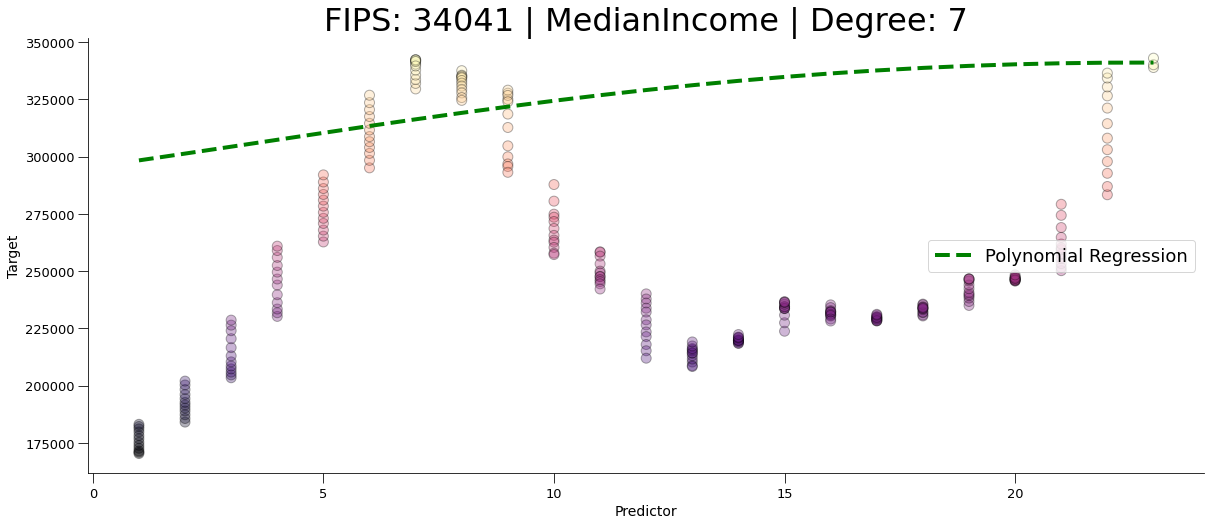

In [248]:

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
#plt.rcParams['legend.title_fontsize'] = 'xx-large'
fig = plt.figure(figsize = (20,8))
plt.title(f'FIPS: {county} | {dependent_var} | Degree: {degree}', fontsize = 32)
ax = sns.scatterplot(data = reduced,
                     x = reduced['YearID'],
                     y = 'MedianHousePrice',
                     hue = 'MedianHousePrice',
                     palette = 'magma', 
                     s = 100,
                     alpha = .32, 
                     edgecolor = 'black', 
                     linewidth = 1,
                     legend = False)

plt.plot(x_poly, poly_pred, color = 'green', linewidth = 4, linestyle= 'dashed', label = 'Polynomial Regression')

ax.set_xlabel('Predictor', fontsize = 14)
ax.set_ylabel('Target', fontsize = 14)
ax.tick_params(size = 10)
ax.legend(fontsize = 18, markerscale = 1, loc = 5)
sns.despine()
fig.show()